In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import pyntcloud
from pyntcloud import PyntCloud
import scipy
from sklearn.neighbors import NearestNeighbors
import itertools
from scipy import linalg
import matplotlib as mpl
import src.realsense.dataset as rld
import src.realsense.camera as rlc
import src.visual3d.geometry as geom
import rosbag
from scipy import linalg
from sklearn import mixture
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.animation as manimation
from IPython.display import Video

print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


In [2]:
# frame from bags
bag_name = 'single_layer'
np.random.seed(0)
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(f"data/{bag_name}.bag")
profile = pipe.start(cfg)


In [3]:

# Skip 5 first frames to give the Auto-Exposure time to adjust
frame_idx = 4
for x in range(frame_idx-1):
    pipe.wait_for_frames()

# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# visualize the capture frame
color = np.asanyarray(color_frame.get_data())
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
H,W = color.shape[:2]
gray = np.mean(colorized_depth,axis=2).astype(np.uint8)

# align rgb and depth image
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = np.asanyarray(aligned_depth_frame.get_data())
depth = depth*depth_scale

# get intrinsics
bag = rosbag.Bag('data/with_objects_multi_layer.bag')
count_loop = 0
for topic, msg, t in bag.read_messages():
    if 'Color_0/info/camera_info' in topic:
        K = msg.K
    count_loop +=1
    if count_loop > 20:
        break
bag.close()
K = np.array(K).reshape(3,3)

# simple plane segmentation
from sklearn import linear_model
xyz,rgb = rlc.project_rgbd2pcd(color,depth,K) # project to point cloud
idx = xyz[:,2]>0.001
xyz = xyz[idx,:]; rgb = rgb[idx,:]
xy = xyz[:,:2]; z=xyz[:,2]
reg = linear_model.LinearRegression()
reg.fit(xy,z)
class_binary = (z - (xy @ reg.coef_ + reg.intercept_) ) < -0.030
xyz_top = xyz[class_binary,:]
rgb_top = rgb[class_binary,:]
xyz_bottom = xyz[~class_binary,:]
rgb_bottom = rgb[~class_binary,:]
color_top, depth_top = rlc.project_pcd2rgb(xyz_top,rgb_top,H,W,K)

# prepare for GMM
x_idx = np.array([range(W) for _ in range(H)])
y_idx = np.array([range(H) for _ in range(W)]).T
binary_depth = depth_top > 0.001
gmm_x = x_idx[binary_depth].reshape(-1)
gmm_y = y_idx[binary_depth].reshape(-1)
gmm_xy = np.c_[gmm_x,gmm_y]



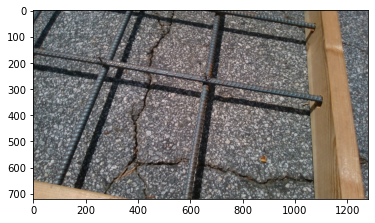

In [4]:
plt.imshow(color)


In [5]:
filename = f"rebar_rgb_{bag_name}{frame_idx}.npy"
root = "data/rebar/"
# np.save(root+filename,rgb_top)
# print("saving " + root + filename)

In [8]:
hsv = mpl.colors.rgb_to_hsv(rgb_bottom)
hsv[:,2] = hsv[:,2]/255.
# idx = (hsv[:,0]> 0.3) & (hsv[:,0]<0.7)
# xyz_filtered = xyz_top[idx,:]
# hsv_filtered = hsv[idx,:]
# rgb_filtered = rgb_top[idx,:]

pcd = geom.PointCloud(xyz = hsv)
pcd.rgb = rgb_bottom
v = pcd.show()
v.set(point_size=0.01)

pcd = geom.PointCloud(xyz = rgb_bottom)
pcd.rgb = rgb_bottom
v = pcd.show()


pcd = geom.PointCloud(xyz = xyz_bottom)
pcd.rgb = rgb_bottom
v = pcd.show()

pcd = geom.PointCloud(xyz = xyz_top)
pcd.rgb = rgb_top
v = pcd.show()
# pcd = geom.PointCloud(xyz = xyz_filtered)
# pcd.rgb = rgb_filtered
# v = pcd.show()


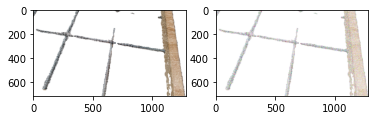

In [7]:
idx = np.random.rand(*color_top.shape) < 0.50
color_top_ransac = np.ones_like(color_top).astype(np.uint8)*255
color_top_ransac[idx] = color_top[idx] 
plt.subplot(1,2,1)
plt.imshow(color_top)
plt.subplot(1,2,2)
plt.imshow(color_top_ransac)